<a href="https://colab.research.google.com/github/Yukinee07/machine-learn/blob/main/Emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uploading the Dataset

In [ ]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('images')

Saving archive.zip to archive.zip


Importing Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image

Data Preparation

In [ ]:
# Set random seeds for reproducible results
tf.random.set_seed(42)
np.random.seed(42)

# Setting the dataset path here
DATASET_PATH = "images/train"

# Setting emotion folder names
EMOTION_FOLDERS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

def load_images_from_folders(dataset_path, emotion_folders, target_size=(48, 48)):
    images = []
    labels = []

    print(f"Loading images from: {dataset_path}")

    for emotion_idx, emotion_folder in enumerate(emotion_folders):
        emotion_path = os.path.join(dataset_path, emotion_folder)

        if not os.path.exists(emotion_path):
            print(f"Warning: Folder '{emotion_folder}' not found. Skipping...")
            continue

        print(f"Loading {emotion_folder} images...")
        image_count = 0

        # Get all image files in the folder
        for filename in os.listdir(emotion_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                image_path = os.path.join(emotion_path, filename)

                try:
                    # Load and preprocess image
                    img = Image.open(image_path)

                    # Convert to grayscale if needed
                    if img.mode != 'L':
                        img = img.convert('L')

                    # Resize image
                    img = img.resize(target_size)

                    # Convert to numpy array and normalize
                    img_array = np.array(img) / 255.0

                    images.append(img_array)
                    labels.append(emotion_idx)
                    image_count += 1

                except Exception as e:
                    print(f"Error loading {image_path}: {e}")
                    continue

        print(f"  Loaded {image_count} images from {emotion_folder}")

    images = np.array(images)
    labels = np.array(labels)

    # Add channel dimension for CNN (grayscale = 1 channel)
    images = images.reshape(-1, target_size[0], target_size[1], 1)

    print(f"\nTotal images loaded: {len(images)}")
    print(f"Image shape: {images.shape}")
    print(f"Unique emotions: {len(np.unique(labels))}")

    return images, labels

def auto_detect_folders(dataset_path):
    """
    Automatically detect emotion folders in the dataset path
    """
    if not os.path.exists(dataset_path):
        return None

    folders = [f for f in os.listdir(dataset_path)
              if os.path.isdir(os.path.join(dataset_path, f))]

    print(f"Found folders: {folders}")
    return sorted(folders)

# Try to auto-detect folders first
if os.path.exists(DATASET_PATH):
    detected_folders = auto_detect_folders(DATASET_PATH)
    if detected_folders:
        print(f"Auto-detected emotion folders: {detected_folders}")
        EMOTION_FOLDERS = detected_folders

# Load the data
images, emotions = load_images_from_folders(DATASET_PATH, EMOTION_FOLDERS)

# Update emotion labels to match the actual folders
emotion_labels = [folder.capitalize() for folder in EMOTION_FOLDERS]
print(f"Emotion labels: {emotion_labels}")

Found folders: ['fear', 'sad', 'neutral', 'happy', 'disgust', 'surprise', 'angry']
Auto-detected emotion folders: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Loading images from: images/train
Loading angry images...
  Loaded 3995 images from angry
Loading disgust images...
  Loaded 436 images from disgust
Loading fear images...
  Loaded 4097 images from fear
Loading happy images...
  Loaded 7215 images from happy
Loading neutral images...
  Loaded 4965 images from neutral
Loading sad images...
  Loaded 4830 images from sad
Loading surprise images...
  Loaded 3171 images from surprise

Total images loaded: 28709
Image shape: (28709, 48, 48, 1)
Unique emotions: 7
Emotion labels: ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


Loading Training and Validation Sets

In [ ]:
# Split data: 80% train, 10% validation, 10% test
from sklearn.model_selection import train_test_split

# Check if we have enough data for each class
unique, counts = np.unique(emotions, return_counts=True)
min_samples = min(counts)

if min_samples < 10:
    print(f"Warning: Some emotions have very few samples (min: {min_samples})")

X_temp, X_test, y_temp, y_test = train_test_split(
    images, emotions, test_size=0.10, random_state=42,
    stratify=emotions if min_samples >= 2 else None
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, random_state=42,
    stratify=y_temp if min_samples >= 3 else None
)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

# Convert labels to categorical (one-hot encoding)
num_classes = len(emotion_labels)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

Training set: 22969 images
Validation set: 2869 images
Test set: 2871 images


Creating the CNN Model

In [ ]:
def create_simple_cnn(input_shape, num_classes):
    """
    Create a simple CNN model for emotion detection
    """
    model = tf.keras.Sequential([
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        # Flatten and dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = X_train.shape[1:]
num_classes = len(emotion_labels)

# Create the model
model = create_simple_cnn(input_shape, num_classes)

# Display model architecture
print("\nModel Architecture:")
model.summary()

# Compiling the model
model.compile(
    optimizer='adam',                         # Adam optimizer works well out of the box
    loss='categorical_crossentropy',
    metrics=['accuracy']                      # Track accuracy during training
)


Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,295 (4.38 MB)

 Trainable params: 1,146,823 (4.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

Data Augmentation

In [ ]:
# Create data augmentation generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,          # Rotate images randomly by up to 10 degrees
    width_shift_range=0.1,      # Shift images horizontally by up to 10%
    height_shift_range=0.1,     # Shift images vertically by up to 10%
    horizontal_flip=True,       # Randomly flip images horizontally
    zoom_range=0.1,             # Randomly zoom in/out by up to 10%
    fill_mode='nearest'         # Fill in new pixels with nearest pixel values
)

# Fit the augmentation generator on training data
datagen.fit(X_train)

Training the Model

In [ ]:
# Setting up callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,                 # Stop training if validation loss doesn't improve for 5 epochs
        restore_best_weights=True   # Restore the best weights when stopping
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,                 # Reduce learning rate by half
        patience=3,                 # Reduce LR if no improvement for 3 epochs
        min_lr=0.0001               # Don't reduce LR below this value
    )
]

#Train the model
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    epochs=7,
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/7


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 155s 206ms/step - accuracy: 0.2216 - loss: 2.4613 - val_accuracy: 0.2673 - val_loss: 2.1660 - learning_rate: 0.0010
Epoch 2/7
718/718 ━━━━━━━━━━━━━━━━━━━━ 140s 195ms/step - accuracy: 0.3160 - loss: 1.7631 - val_accuracy: 0.3688 - val_loss: 1.6998 - learning_rate: 0.0010
Epoch 3/7
718/718 ━━━━━━━━━━━━━━━━━━━━ 141s 194ms/step - accuracy: 0.3904 - loss: 1.5829 - val_accuracy: 0.4193 - val_loss: 1.4271 - learning_rate: 0.0010
Epoch 4/7
718/718 ━━━━━━━━━━━━━━━━━━━━ 141s 196ms/step - accuracy: 0.4060 - loss: 1.5283 - val_accuracy: 0.4465 - val_loss: 1.4862 - learning_rate: 0.0010
Epoch 5/7
718/718 ━━━━━━━━━━━━━━━━━━━━ 142s 197ms/step - accuracy: 0.4210 - loss: 1.5103 - val_accuracy: 0.4866 - val_loss: 1.3152 - learning_rate: 0.0010
Epoch 6/7
718/718 ━━━━━━━━━━━━━━━━━━━━ 136s 190ms/step - accuracy: 0.4389 - loss: 1.4486 - val_accuracy: 0.4869 - val_loss: 1.3342 - learning_rate: 0.0010
Epoch 7/7
718/718 ━━━━━━━━━━━━━━━━━━━━ 144s 193ms/step - accuracy: 0.4553 - loss

Model Evaluation


Test Accuracy: 0.5162
Test Loss: 1.2811
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step

Classification Report:
              precision    recall  f1-score   support

       Angry       0.42      0.39      0.41       399
     Disgust       0.09      0.02      0.04        44
        Fear       0.42      0.09      0.14       410
       Happy       0.75      0.75      0.75       722
     Neutral       0.43      0.60      0.51       496
         Sad       0.37      0.47      0.41       483
    Surprise       0.58      0.69      0.63       317

    accuracy                           0.52      2871
   macro avg       0.44      0.43      0.41      2871
weighted avg       0.51      0.52      0.49      2871



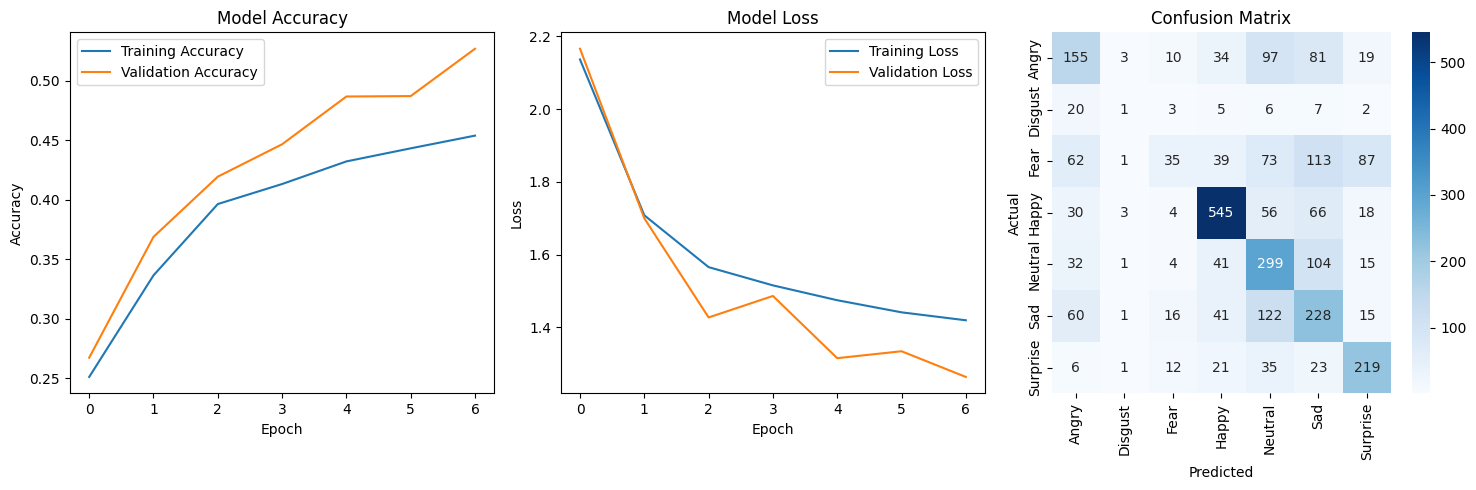

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=emotion_labels))


# Plot training history
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot confusion matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

Testing on Individual Images

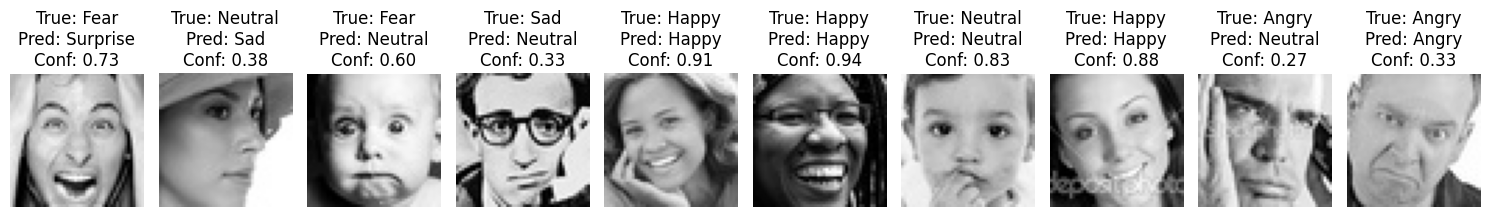

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted emotion: Happy (confidence: 0.98)


In [ ]:
if len(X_test) > 0:
    num_test_images = min(10, len(X_test))
    test_indices = np.random.choice(len(X_test), num_test_images, replace=False)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(test_indices):
        image = X_test[idx]
        true_emotion = emotion_labels[y_test[idx]]

        # Make prediction
        pred = model.predict(image.reshape(1, *image.shape), verbose=0)
        predicted_emotion = emotion_labels[np.argmax(pred)]
        confidence = np.max(pred)

        plt.subplot(1, num_test_images, i+1)
        plt.imshow(image.reshape(input_shape[0], input_shape[1]), cmap='gray')
        plt.title(f'True: {true_emotion}\nPred: {predicted_emotion}\nConf: {confidence:.2f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load and predict on new image
def predict_emotion(image_path):
    img = Image.open(image_path)
    img = img.convert('L')  # Convert to grayscale
    img = img.resize((48, 48))  # Resize to model input size
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 48, 48, 1)

    prediction = model.predict(img_array)
    emotion_index = np.argmax(prediction)
    confidence = prediction[0][emotion_index]

    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    return emotions[emotion_index], confidence

# Use it
emotion, confidence = predict_emotion('images/test/happy/PrivateTest_3524293.jpg')
print(f"Predicted emotion: {emotion} (confidence: {confidence:.2f})")